In this notebook, we construct a convolutional neural network to classify the CIFAR data set. See [here](https://www.cs.toronto.edu/~kriz/cifar.html) for more information. Again, Keras supplies this data set built in.

We'll also take a look at some best practices to see which model works best...

In [ ]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

Again, we preprocess the data set similarly as how we did for MNIST. Note that each image already has a depth of 3 (three color channels), so we don't need to expand the dimensions here.

In [ ]:
num_classes = 10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255
X_test  /= 255
y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test, num_classes)

print(X_train.shape)

170500096/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3)


Let's take a look at an example image to see what we're working with:

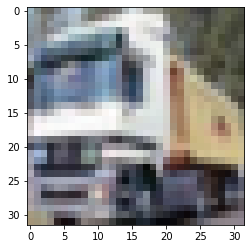

In [ ]:
plt.imshow(X_train[1])
plt.show()

CIFAR10 has the following classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

We're going to compare a couple for models here to see which one performs best, so we create a bunch of helper functions to construct them for us.

In [ ]:
def traditional_cnn(input_shape=(32, 32, 3), num_classes=10):
  model = Sequential()
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

def nopool_cnn(input_shape=(32, 32, 3), num_classes=10):
  model = Sequential()
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

def deeper_cnn(input_shape=(32, 32, 3), num_classes=10):
  model = Sequential()
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

def deeper_cnn_dropout(input_shape=(32, 32, 3), num_classes=10):
  model = Sequential()
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(num_classes, activation='softmax'))
  return model

def deeper_cnn_dropout_batchnorm(input_shape=(32, 32, 3), num_classes=10):
  model = Sequential()
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Dense(num_classes, activation='softmax'))
  return model

def deeper_cnn_dropout_batchnorm_gap(input_shape=(32, 32, 3), num_classes=10):
  model = Sequential()
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(512, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(num_classes, activation='softmax'))
  return model

In [ ]:
models = { name : globals()[name]()
  for name in [
    'traditional_cnn',
    'nopool_cnn',
    'deeper_cnn',
    'deeper_cnn_dropout',
    'deeper_cnn_dropout_batchnorm',
    'deeper_cnn_dropout_batchnorm_gap'
  ]
}

Next, we train each model for 15 epochs and compare to see which one obtains the best result, and which one prevents best against overfitting...

In [ ]:
batch_size = 128
epochs     = 15
history    = {}

for name, model in models.items():
  print('Training', name)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history[name] = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
                            validation_data=(X_test, y_test))

Training traditional_cnn
Training nopool_cnn
Training deeper_cnn
Training deeper_cnn_dropout
Training deeper_cnn_dropout_batchnorm
Training deeper_cnn_dropout_batchnorm_gap


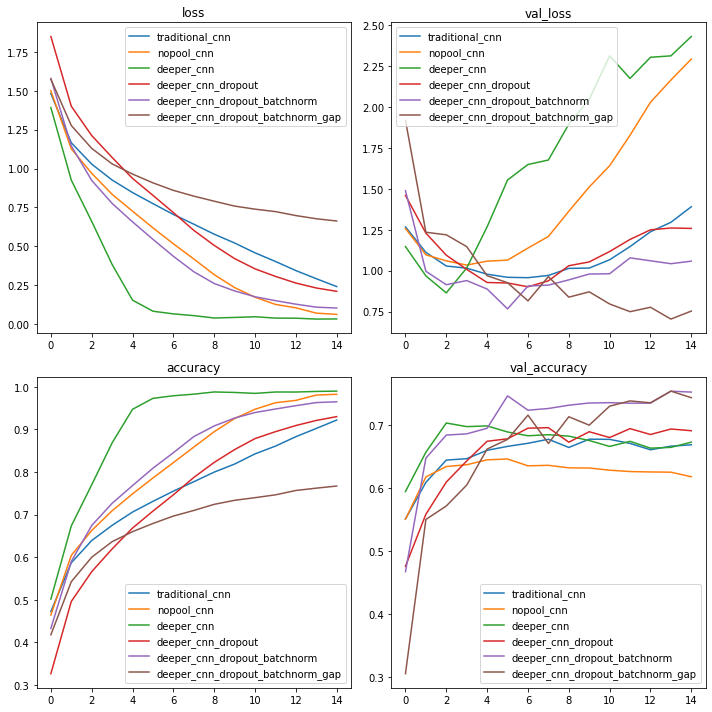

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
for name in history:
  
  ax[0][0].plot(history[name].history['loss'], label=name); ax[0][0].set_title('loss')
  ax[0][0].legend()

  ax[0][1].plot(history[name].history['val_loss'], label=name); ax[0][1].set_title('val_loss')
  ax[0][1].legend()

  ax[1][0].plot(history[name].history['accuracy'], label=name); ax[1][0].set_title('accuracy')
  ax[1][0].legend()

  ax[1][1].plot(history[name].history['val_accuracy'], label=name); ax[1][1].set_title('val_accuracy')
  ax[1][1].legend()
  
plt.tight_layout()

Based on the results above, we can make a couple of observations. First, the traditional approach does a rather poor job. The deeper version reaches a high accuracy very quickly, but is also prone to overfitting. Removing the pooling layer, together with using dropout and batch normalization helps a lot given enough epochs. Also using global average pooling leads to the highest accuracy overall.

Things to try:

- Can you come up with an architecture that works even better? (E.g. try adding padding to every convolutional layer in the deeper architectures.)
- For example, try adding in batch normalization on top of the convolutional layers as well, try playing around with number of filters, kernel size, etc.
- Look up what a padding of "same" means in Keras. Try changing all convolutional layers to use this padding. Try changing this to zero padding using [`ZeroPadding2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D).
- Another thing to try out is to play around with the learning rate using some of the references discussed in the course.
- Finally, try looking for a solution to perform image augmentation, e.g. take a look at how you can use the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class.